[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dougc333/Colab-Notebooks/blob/main/vllm_viz.ipynb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


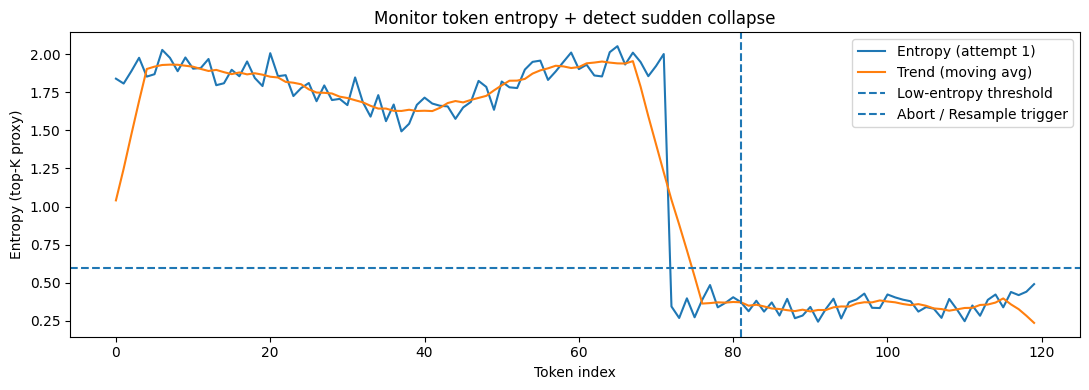

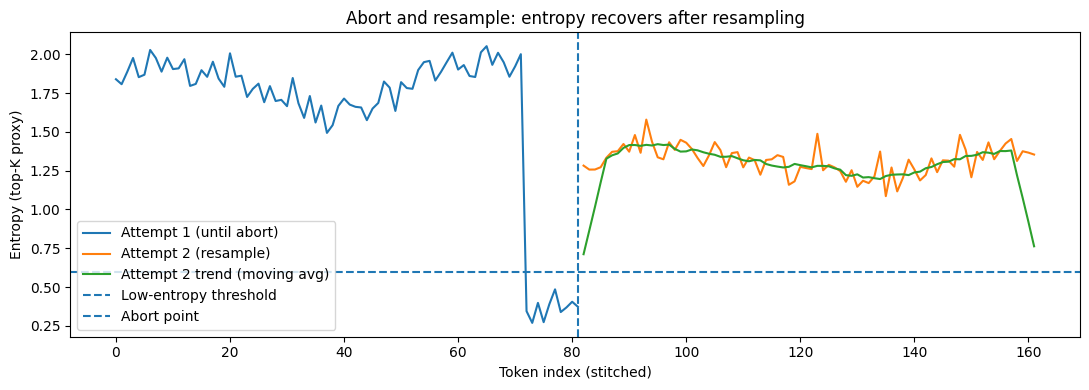

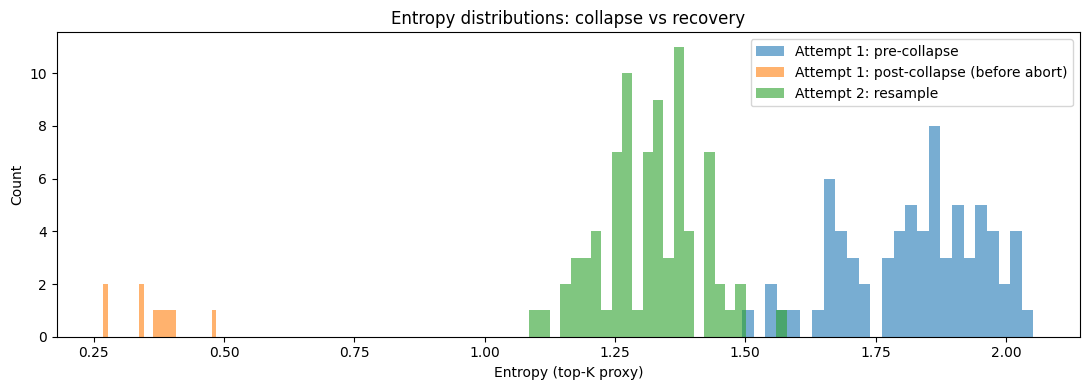

{'collapse_at_token': 72, 'trigger_token': 81, 'abort_token': 81, 'low_entropy_threshold': 0.6, 'window': 10, 'min_drop': 0.8, 'patience': 2}


In [1]:
# Colab-ready: create 3 graphs illustrating
# 1) monitor token entropy
# 2) detect sudden entropy collapse
# 3) abort + resample and show recovery
#
# This uses synthetic entropy traces (top-K proxy) so it runs anywhere.
# Swap H1/H2 with real streaming entropies from vLLM to use on live data.

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Synthetic "entropy stream" data
# -----------------------------
np.random.seed(42)

T1 = 120  # tokens in attempt 1 (before abort)
T2 = 80   # tokens in attempt 2 (resample)

t1 = np.arange(T1)
t2 = np.arange(T2)

# Attempt 1 entropy: healthy then sudden collapse
H1 = 1.8 + 0.15*np.sin(t1/8) + 0.08*np.random.randn(T1)
collapse_at = 72
H1[collapse_at:] = 0.35 + 0.05*np.sin(t1[collapse_at:]/3) + 0.05*np.random.randn(T1 - collapse_at)

# Attempt 2 entropy: recovery after resample
H2 = 1.3 + 0.10*np.sin(t2/10) + 0.07*np.random.randn(T2)
H2 = np.clip(H2, 0.2, None)

# -----------------------------
# Collapse detection (illustrative)
# -----------------------------
window = 10
low_H = 0.6
min_drop = 0.8
patience = 2

# Sudden drop events
drop_events = np.zeros(T1, dtype=int)
for i in range(1, T1):
    if H1[i] < H1[i-1] - min_drop:
        drop_events[i] = 1

# Sustained low entropy events
sustained_low = np.zeros(T1, dtype=int)
for i in range(window - 1, T1):
    if np.all(H1[i - window + 1:i + 1] < low_H):
        sustained_low[i] = 1

# Trigger: (>=patience sudden drops) OR sustained low
trigger_idx = None
drop_count = 0
for i in range(T1):
    drop_count += drop_events[i]
    if drop_count >= patience or sustained_low[i] == 1:
        trigger_idx = i
        break

abort_at = trigger_idx if trigger_idx is not None else T1 - 1

# Simple smoothing for trend lines
def moving_average(x, w):
    if w <= 1:
        return x
    k = np.ones(w) / w
    return np.convolve(x, k, mode="same")

H1_tr = moving_average(H1, 9)
H2_tr = moving_average(H2, 9)

# -----------------------------
# Plot 1: Token entropy + collapse detection + abort point
# -----------------------------
plt.figure(figsize=(11, 4))
plt.plot(t1, H1, label="Entropy (attempt 1)")
plt.plot(t1, H1_tr, label="Trend (moving avg)")
plt.axhline(low_H, linestyle="--", label="Low-entropy threshold")
if trigger_idx is not None:
    plt.axvline(abort_at, linestyle="--", label="Abort / Resample trigger")
plt.xlabel("Token index")
plt.ylabel("Entropy (top-K proxy)")
plt.title("Monitor token entropy + detect sudden collapse")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Abort then resample (stitched timeline)
# -----------------------------
t_all_1 = np.arange(abort_at + 1)
t_all_2 = np.arange(T2) + (abort_at + 1)  # starts immediately after abort

plt.figure(figsize=(11, 4))
plt.plot(t_all_1, H1[:abort_at + 1], label="Attempt 1 (until abort)")
plt.plot(t_all_2, H2, label="Attempt 2 (resample)")
plt.plot(t_all_2, H2_tr, label="Attempt 2 trend (moving avg)")
plt.axhline(low_H, linestyle="--", label="Low-entropy threshold")
plt.axvline(abort_at, linestyle="--", label="Abort point")
plt.xlabel("Token index (stitched)")
plt.ylabel("Entropy (top-K proxy)")
plt.title("Abort and resample: entropy recovers after resampling")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: Entropy distributions (pre-collapse vs post-collapse vs resample)
# -----------------------------
pre = H1[:collapse_at]
post = H1[collapse_at:abort_at + 1] if abort_at >= collapse_at else np.array([])
res = H2

plt.figure(figsize=(11, 4))
plt.hist(pre, bins=25, alpha=0.6, label="Attempt 1: pre-collapse")
if len(post) > 0:
    plt.hist(post, bins=25, alpha=0.6, label="Attempt 1: post-collapse (before abort)")
plt.hist(res, bins=25, alpha=0.6, label="Attempt 2: resample")
plt.xlabel("Entropy (top-K proxy)")
plt.ylabel("Count")
plt.title("Entropy distributions: collapse vs recovery")
plt.legend()
plt.tight_layout()
plt.show()

print({
    "collapse_at_token": int(collapse_at),
    "trigger_token": None if trigger_idx is None else int(trigger_idx),
    "abort_token": int(abort_at),
    "low_entropy_threshold": float(low_H),
    "window": int(window),
    "min_drop": float(min_drop),
    "patience": int(patience),
})